### Vary bias in labels $\mathbf{Z}$
For a $G$-community SBM, where $G$ is the number of groups, vary the bias of the network with nodes in different groups.
In particular, the unfair node label set contains labels that match community assignment.
For problem settings that become more fair, replace an increasing number of labels with randomly sampled Bernoulli random variables.

In [2]:
from utils import *
from opt import *
from time import perf_counter


In [22]:
edge_prob = .2
p = 20
n = 1000
g = 2

NUM_SWAPPED_LABELS = np.arange(2,5)
num_params = len(NUM_SWAPPED_LABELS)

z_orig = np.ones(p, dtype=int)
z_orig[:int(p/2)] = 0

mu1 = .01
mu2 = .5
epsilon = 1e-6
bias_type = 'dp'
eta = .02
iters = 1000

num_trials = 5


In [39]:
grp_in_clust_range = np.zeros((num_trials,num_params))

bias_true = np.zeros((num_trials,num_params))

frob_err_glasso = np.zeros((num_trials,num_params))
f1_score_glasso = np.zeros((num_trials,num_params))
time_run_glasso = np.zeros((num_trials,num_params))
bias_glasso = np.zeros((num_trials,num_params))

frob_err_dp = np.zeros((num_trials,num_params))
f1_score_dp = np.zeros((num_trials,num_params))
time_run_dp = np.zeros((num_trials,num_params))
bias_dp = np.zeros((num_trials,num_params))

frob_err_nodewise = np.zeros((num_trials,num_params))
f1_score_nodewise = np.zeros((num_trials,num_params))
time_run_nodewise = np.zeros((num_trials,num_params))
bias_nodewise = np.zeros((num_trials,num_params))

for t in range(num_trials):
    A = generate_ksbm(p,2,.2,.05,z_orig)
    Sigma, Theta = create_mtp2_cov(A)
    Theta_od = Theta*(1-np.eye(p))
    X = np.random.multivariate_normal(np.zeros(p), Sigma, n)
    Sigma_hat = X.T@X/n

    for i,swap in enumerate(NUM_SWAPPED_LABELS):
        print(f"Number of randomized labels: {swap} | Trial {t+1} of {num_trials}")

        z = z_orig.copy()
        rand_ind0 = np.random.choice(np.where(z_orig==0)[0],swap,replace=False)
        rand_ind1 = np.random.choice(np.where(z_orig==1)[0],swap,replace=False)
        z[rand_ind0] = 1 - z[rand_ind0]
        z[rand_ind1] = 1 - z[rand_ind1]
        Z = np.eye(g)[z].T
        bias_true[t,i] = compute_dp2(Theta,Z)
        grp_in_clust_range[t,i] = np.sum((z==0)*(z_orig==0))/np.sum(z_orig==0)

        tic = perf_counter()
        Theta_glasso = node_FGL_fista(Sigma_hat, mu1, eta, 0, Z, 'dp', epsilon, iters, False)
        toc = perf_counter()
        frob_err_glasso[t,i] = compute_frob_err(Theta_glasso, Theta)
        f1_score_glasso[t,i] = compute_f1_score(Theta_glasso, Theta,.1)
        time_run_glasso[t,i] = np.abs(toc-tic)
        bias_glasso[t,i] = compute_dp2(Theta_glasso, Z)
        print( '    ' +
            'GLASSO: ' + 
            f'Err: {frob_err_glasso[t,i]:.4f} | ' +
            f'F1: {f1_score_glasso[t,i]:.4f} | ' +
            f'Time: {time_run_glasso[t,i]:.4f} | ' +
            f'Bias: {bias_glasso[t,i]:.4f} - {bias_true[t,i]:.4f}')

        tic = perf_counter()
        Theta_dp = node_FGL_fista(Sigma_hat, mu1, eta, mu2, Z, 'dp', epsilon, iters, False)
        toc = perf_counter()
        frob_err_dp[t,i] = compute_frob_err(Theta_dp, Theta)
        f1_score_dp[t,i] = compute_f1_score(Theta_dp, Theta,.1)
        time_run_dp[t,i] = np.abs(toc-tic)
        bias_dp[t,i] = compute_dp2(Theta_dp, Z)
        print( '    ' +
            'DP:     ' + 
            f'Err: {frob_err_dp[t,i]:.4f} | ' +
            f'F1: {f1_score_dp[t,i]:.4f} | ' +
            f'Time: {time_run_dp[t,i]:.4f} | ' +
            f'Bias: {bias_dp[t,i]:.4f} - {bias_true[t,i]:.4f}')

        tic = perf_counter()
        Theta_nodewise = node_FGL_fista(Sigma_hat, mu1, eta, mu2, Z, 'nodewise', epsilon, iters, False)
        toc = perf_counter()
        frob_err_nodewise[t,i] = compute_frob_err(Theta_nodewise, Theta)
        f1_score_nodewise[t,i] = compute_f1_score(Theta_nodewise, Theta,.1)
        time_run_nodewise[t,i] = np.abs(toc-tic)
        bias_nodewise[t,i] = compute_dp2(Theta_nodewise, Z)
        print( '    ' +
            'Nw. DP: ' + 
            f'Err: {frob_err_nodewise[t,i]:.4f} | ' +
            f'F1: {f1_score_nodewise[t,i]:.4f} | ' +
            f'Time: {time_run_nodewise[t,i]:.4f} | ' +
            f'Bias: {bias_nodewise[t,i]:.4f} - {bias_true[t,i]:.4f}')


Number of randomized labels: 2 | Trial 1 of 5
    GLASSO: Err: 0.0125 | F1: 0.8065 | Time: 0.2537 | Bias: 0.0017 - 0.0047
    DP:     Err: 0.0126 | F1: 0.8065 | Time: 0.2300 | Bias: 0.0015 - 0.0047
    Nw. DP: Err: 0.0130 | F1: 0.8065 | Time: 1.4246 | Bias: 0.0013 - 0.0047
Number of randomized labels: 3 | Trial 1 of 5
    GLASSO: Err: 0.0125 | F1: 0.8065 | Time: 0.2209 | Bias: 0.0014 - 0.0027
    DP:     Err: 0.0125 | F1: 0.8065 | Time: 0.2207 | Bias: 0.0013 - 0.0027
    Nw. DP: Err: 0.0128 | F1: 0.8065 | Time: 1.1537 | Bias: 0.0013 - 0.0027
Number of randomized labels: 4 | Trial 1 of 5
    GLASSO: Err: 0.0125 | F1: 0.8065 | Time: 0.2755 | Bias: 0.0011 - 0.0024
    DP:     Err: 0.0125 | F1: 0.8065 | Time: 0.2757 | Bias: 0.0010 - 0.0024
    Nw. DP: Err: 0.0129 | F1: 0.8065 | Time: 1.4127 | Bias: 0.0010 - 0.0024
Number of randomized labels: 2 | Trial 2 of 5
    GLASSO: Err: 0.0049 | F1: 1.0000 | Time: 0.2643 | Bias: 0.0021 - 0.0036
    DP:     Err: 0.0049 | F1: 1.0000 | Time: 0.2919 | Bi

array([0.8, 0.7, 0.6])

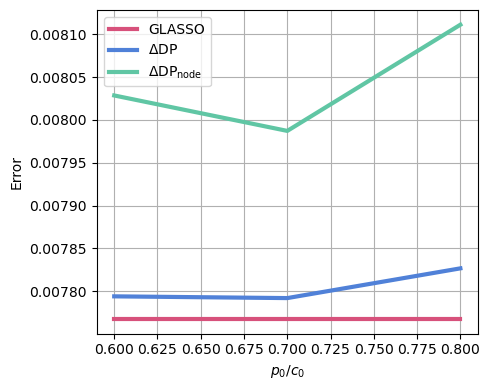

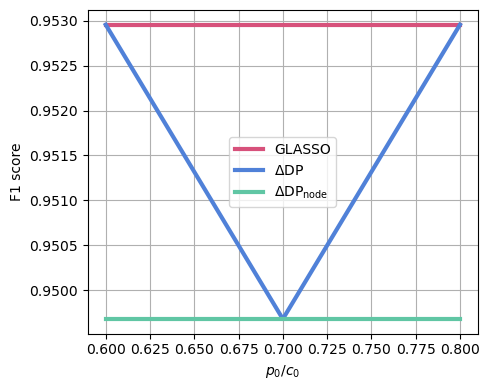

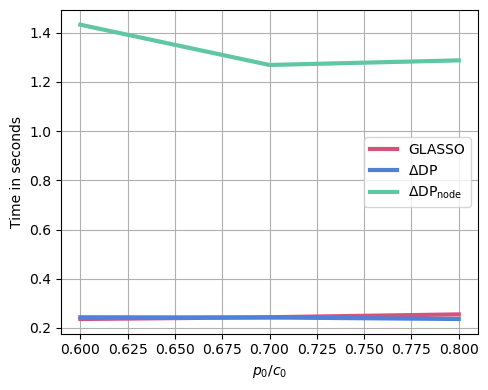

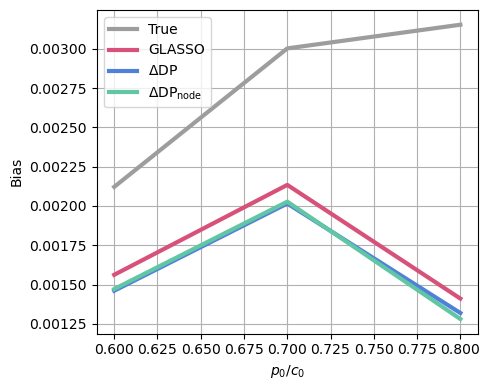

In [43]:
x_label = r'No. swapped labels'
x_range = NUM_SWAPPED_LABELS
x_label = r'$p_0 / c_0$'
x_range = grp_in_clust_range.mean(0)

plt_args = { 'linewidth':3 }

y_label = 'Error'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = frob_err_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = frob_err_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = frob_err_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()



y_label = 'F1 score'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = f1_score_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = f1_score_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = f1_score_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Time in seconds'
y_range = time_run_glasso.mean(0)
clr = greens[10]
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = time_run_glasso.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = time_run_dp.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = time_run_nodewise.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

y_label = 'Bias'
fig = plt.figure(figsize=(5,4))
ax = fig.subplots()

y_range = bias_true.mean(0)
ax.plot(x_range, y_range, c=grays[10], **plt_args, label='True')

y_range = bias_glasso.mean(0)
# y_range = bias_glasso.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=reds[10], **plt_args, label='GLASSO')

y_range = bias_dp.mean(0)
# y_range = bias_dp.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=blues[10], **plt_args, label=r'$\Delta \mathrm{DP}$')

y_range = bias_nodewise.mean(0)
# y_range = bias_nodewise.mean(0) - bias_true.mean(0)
ax.plot(x_range, y_range, c=greens[10], **plt_args, label=r'$\Delta \mathrm{DP}_{\mathrm{node}}$')

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.legend()
ax.grid(True)
fig.tight_layout()

